In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "/project/remote/golmi-dynamatt")
sys.path

import json
import os

import matplotlib.pyplot as plt

from model.pentomino import PieceConfig, RelPositions, Board

def draw_piece_image(color, shape):
    target = PieceConfig(color, shape, RelPositions.CENTER)
    board = Board(15, 15)  # we need at least size of 3 * 5
    board.add_piece_from_config(target)
    arr = board.to_rgb_array()
    center = arr[5:10, 5:10]
    return center

def to_piece_image_name(color, shape):
    return f"{shape.value_name}_{color.value_name}.png"

def save_piece_image(color, shape, target_dir):
    filename = to_piece_image_name(color, shape)
    plt.axis("off")
    plt.imshow(draw_piece_image(color, shape))
    plt.savefig(target_dir + f"/{filename}", bbox_inches='tight')
    return filename

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from model.pentomino import Shapes, Colors
shapes = list(Shapes)
colors = list(Colors)
num_colors = len(colors)
num_shapes = len(shapes)
num_target_looks = num_shapes * num_colors
print(f"Shapes: {num_shapes} Colors: {num_colors} Combinations: {num_target_looks}")

Shapes: 12 Colors: 12 Combinations: 144


In [4]:
# NOTE: Actually more sensible to store all possible combinations of pieces only once!
# And then load them dynamically
num_distractors = 2
num_pieces = num_distractors + 1
print(f"Possible sets: {(num_target_looks)**(num_pieces)}")

Possible sets: 2985984


In [5]:
# Compositional set on "Colors"
print("====== COLORS ========")
# All other distractors do NOT share the color, but at least one distractor shares the shape
num_other_looks = num_shapes*(num_colors-1) # unshare the color, but allow all shapes
num_share_looks = num_colors-1              # unshare the color, but shares the same shape as the target piece
print(f"Other looks: {num_other_looks}")
print(f"Share looks: {num_share_looks}")

num_sets = num_share_looks * num_other_looks**(num_distractors-1)

# Val/Test set on "Colors" (spare 1 combination of shape + color)
print(f"Possible val/test comp. sets with {num_distractors} distractors: {1 * num_shapes * num_sets}")

# Single piece set on "Colors" (1 combination of shape + color)
print(f"Possible single comp. sets with {num_distractors} distractors: {1 * num_sets}")

print(f"All possible sets with {num_distractors} distractors: {num_target_looks * num_sets}")

====== COLORS ========
Other looks: 132
Share looks: 11
Possible val/test comp. sets with 2 distractors: 17424
Possible single comp. sets with 2 distractors: 1452
All possible sets with 2 distractors: 209088


In [6]:
# Compositional set on "Shapes"
print("====== SHAPES ========")
# All other distractors do NOT share the shape, but at least one distractor shares the color
num_other_looks = num_colors*(num_shapes-1) # unshare the shape, but allow all colors
num_share_looks = num_shapes-1              # unshare the shape, but shares the same color as the target piece
print(f"Other looks: {num_other_looks}")
print( f"Share looks: {num_share_looks}")

num_sets = num_share_looks * num_other_looks**(num_distractors-1)

# Val/Test set on "Colors" (spare 1 combination of shape + color)
print(f"Possible val/test comp. sets with {num_distractors} distractors: {1 * num_shapes * num_sets}")

# Single piece set on "Colors" (1 combination of shape + color)
print(f"Possible single comp. sets with {num_distractors} distractors: {1 * num_sets}")

print(f"All possible sets with {num_distractors} distractors: {num_target_looks * num_sets}")

====== SHAPES ========
Other looks: 132
Share looks: 11
Possible val/test comp. sets with 2 distractors: 17424
Possible single comp. sets with 2 distractors: 1452
All possible sets with 2 distractors: 209088


Pieces: 144


['F_purple.png', 'T_yellow.png', 'I_pink.png', 'V_purple.png', 'I_blue.png']

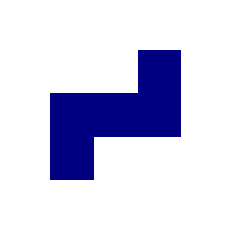

In [7]:
# We create all piece images first
# There are only 96 possible combinations (for now)
save_all_pieces = True
data_images_dir = "/data/compreg/sets/pieces"
if save_all_pieces:  
    for shape_idx, shape in enumerate(shapes):
        for color_idx, color in enumerate(colors):
            save_piece_image(color, shape, data_images_dir)
print("Pieces:", len(os.listdir(data_images_dir)))
os.listdir(data_images_dir)[:5]

In [13]:
f_files = [fn for fn in os.listdir(data_images_dir) if fn[0] == "F"]
len(f_files)

12

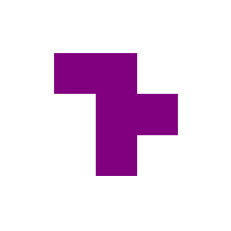

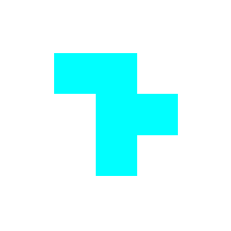

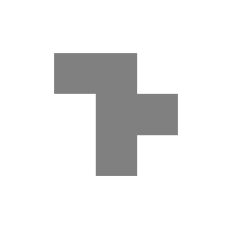

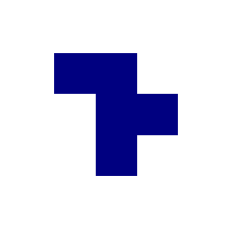

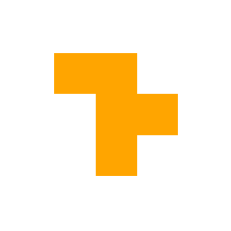

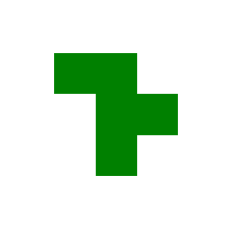

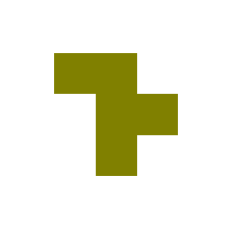

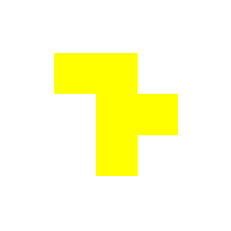

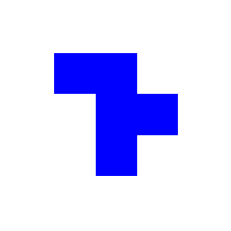

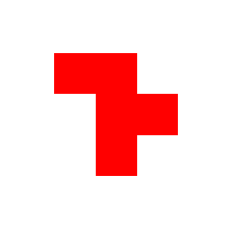

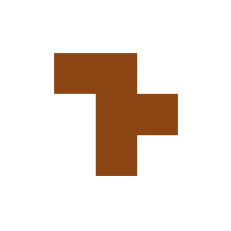

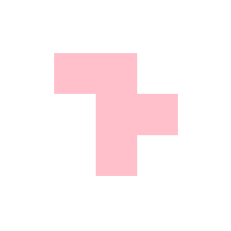

In [15]:
from PIL import Image
import numpy as np

for file in f_files:
    with Image.open(data_images_dir + "/" + file) as im:
        plt.figure()
        plt.axis("off")
        plt.imshow(np.array(im))

# Create meta.json

We map label, colors, shapes etc. to integers

In [17]:
from model.pentomino import PropertyNames
data_top_dir = "/data/compreg/sets"
save_meta = False
uniq_props = [PropertyNames.COLOR, PropertyNames.SHAPE]
if save_meta:
    metadata = {
        "shape_to_idx": dict(),
        "idx_to_shape": dict(),
        "color_to_idx": dict(),
        "idx_to_color": dict(),
        "props_to_idx": dict(),
        "idx_to_props": dict()
    }
    for prop_idx, prop in enumerate(shapes):
        metadata["shape_to_idx"][prop.name] = prop_idx
        metadata["idx_to_shape"][prop_idx] = prop.name
        
    for prop_idx, prop in enumerate(colors):
        metadata["color_to_idx"][prop.name] = prop_idx
        metadata["idx_to_color"][prop_idx] = prop.name
        
    for prop_idx, prop in enumerate(uniq_props):
        metadata["props_to_idx"][prop.name] = prop_idx
        metadata["idx_to_props"][prop_idx] = prop.name
        
    with open(data_top_dir + "/meta.json", "w") as f:
        json.dump(metadata, f, indent=4, sort_keys=True)
else:
    with open(data_top_dir + "/meta.json") as f:
        metadata = json.load(f)
print(metadata)

{'color_to_idx': {'BLUE': 4, 'BROWN': 7, 'CYAN': 5, 'GREEN': 3, 'GREY': 8, 'NAVY': 11, 'OLIVE': 10, 'ORANGE': 1, 'PINK': 9, 'PURPLE': 6, 'RED': 0, 'YELLOW': 2}, 'idx_to_color': {'0': 'RED', '1': 'ORANGE', '2': 'YELLOW', '3': 'GREEN', '4': 'BLUE', '5': 'CYAN', '6': 'PURPLE', '7': 'BROWN', '8': 'GREY', '9': 'PINK', '10': 'OLIVE', '11': 'NAVY'}, 'idx_to_props': {'0': 'COLOR', '1': 'SHAPE'}, 'idx_to_shape': {'0': 'F', '1': 'I', '2': 'L', '3': 'N', '4': 'P', '5': 'T', '6': 'U', '7': 'V', '8': 'W', '9': 'X', '10': 'Y', '11': 'Z'}, 'props_to_idx': {'COLOR': 0, 'SHAPE': 1}, 'shape_to_idx': {'F': 0, 'I': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'U': 6, 'V': 7, 'W': 8, 'X': 9, 'Y': 10, 'Z': 11}}


In [ ]:
list(Colors)

In [ ]:
# We map by enum name because this can automatically be mapped back for example:
Colors["RED"] # note the brackets, no parenthesis!

# The annotation structure

```
[
  {
    "id": 0,
    "unique_prop": 0, # 0: use target color, 1: use target shape to discriminate
    "target": {
        "color": 2,
        "shape": 5,
        "image": "F_blue.png"
    },
    "distractors": [{
        "color": 1,
        "shape": 5,
        "image": "F_red.png"
    },{
        "color": 2,
        "shape": 9,
        "image": "V_blue.png"
    }]
  }
]
```

Note: We produce one sample for each order (although the model should get invariant towards this anyway),
      but it seems easier to generate the dataset in this way (using for-loops) (for now)

In [18]:
from model.pentomino import create_all_distractor_configs, PropertyNames

In [19]:
# Test first on "single piece" combs. (should be 588 ones)
all_configs = create_all_distractor_configs(PieceConfig(Colors.BLUE, Shapes.T, RelPositions.CENTER), 
                                           unique_props={PropertyNames.COLOR},
                                           num_distractors=2,
                                           prop_values={
                                               PropertyNames.COLOR: list(Colors),
                                               PropertyNames.SHAPE: list(Shapes)
                                           })
print("Scenes: ", len(all_configs))

Scenes:  1452


In [40]:
"""
Create for each piece combinations of color and shape, but leave out a combination for val/test. 
The hold-out combinations are never seen during training. Still, every color and shape is seen.

We produce the similiar amount of "mention the color" and "mention the shape" tasks for a combination. 
The meta-task is to find the unique property and extract that value from the target piece.
"""
from tqdm.notebook import tqdm
from model.pentomino import create_all_distractor_configs, PropertyNames, PieceConfig, Shapes, Colors

def generate_all(dry_run=False):
    uniq_props = [PropertyNames.COLOR, PropertyNames.SHAPE]
    num_distractors = 2
    selected_shapes = list(Shapes)
    selected_colors = list(Colors)
    
    total_count = 2 * 209088
    couter_loop=tqdm(range(total_count))
    
    counter = 0
    samples = {
        "train": [],
        "val": [],
        "test": []
    }
    for shape_idx, shape in enumerate(selected_shapes):
        for color_idx, color in enumerate(selected_colors):
            if color_idx == (shape_idx % len(selected_colors)):
                split = "test"
            elif color_idx == (shape_idx + 1 % len(selected_colors)):
                split = "val"
            else:
                split = "train"

            for uniq_prop_idx, uniq_prop in enumerate(uniq_props):
                target_piece = PieceConfig(color=color, shape=shape)
                all_distractor_configs = create_all_distractor_configs(
                    target_piece, unique_props={uniq_prop},
                    num_distractors=num_distractors,
                    prop_values={PropertyNames.COLOR: selected_colors, PropertyNames.SHAPE: selected_shapes })
                for distractor_configs in all_distractor_configs:
                    samples[split].append({
                        "id": counter,
                        "unique_prop": uniq_prop.name,
                        "target": {
                               "color": color.name,
                               "shape": shape.name,
                               "image": to_piece_image_name(color, shape) },
                        "distractors" : [{
                               "color": distractor[PropertyNames.COLOR].name,
                               "shape": distractor[PropertyNames.SHAPE].name,
                               "image": to_piece_image_name(distractor[PropertyNames.COLOR], 
                                                            distractor[PropertyNames.SHAPE])} 
                            for distractor in distractor_configs]
                    })
                    counter += 1
                    couter_loop.update()
                    couter_loop.refresh()
                    if dry_run and counter == 10:
                        return samples
    print("Finished generating...")
    return samples

In [41]:
samples = generate_all()

  0%|          | 0/418176 [00:00<?, ?it/s]

In [42]:
print(sum([len(samples[split]) for split in samples]), 2 * 209088)

418176 418176


In [43]:
for split in samples:
    print(len(samples[split]))

351384
31944
34848


In [44]:
samples["train"][0]

{'id': 5808,
 'unique_prop': 'COLOR',
 'target': {'color': 'YELLOW', 'shape': 'F', 'image': 'F_yellow.png'},
 'distractors': [{'color': 'RED', 'shape': 'F', 'image': 'F_red.png'},
  {'color': 'RED', 'shape': 'F', 'image': 'F_red.png'}]}

In [45]:
for split in samples:
    with open(f"/data/compreg/sets/{num_distractors}dits/{split}.json", "w") as f:
        json.dump(samples[split], f)